<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 2 &ndash; The Vanishing Gradient Problem</h2>

<b>Authors:</b> B. Schäfl, S. Lehner, J. Brandstetter, A. Schörgenhumer<br>
<b>Date:</b> 22-03-2022

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h2>Table of contents</h2>
<ol>
    <a href="#vanishing-gradient-nutshell"><li style="font-size:large;font-weight:bold">The Vanishing Gradient Problem in a Nutshell</li></a>
    <ol style="margin-bottom:15px">
        <a href="#disclaimer"><li style="font-size:medium">Disclaimer</li></a>
        <a href="#fashion-mnist"><li style="font-size:medium">Fashion-MNIST</li></a>
    </ol>
    <a href="#training-neural-network"><li style="font-size:large;font-weight:bold">Training of a Neural Network</li></a>
    <ol style="margin-bottom:15px">
        <a href="#forward-pass"><li style="font-size:medium">Forward pass</li></a>
        <a href="#backward-pass"><li style="font-size:medium">Backward pass</li></a>
    </ol>
    <a href="#logistic-regression"><li style="font-size:large;font-weight:bold">Vanishing Gradients in Logistic Regression</li></a>
    <ol style="margin-bottom:15px">
        <a href="#adding-hidden-layer-one"><li style="font-size:medium">Adding a hidden layer</li></a>
        <a href="#adding-hidden-layer-two"><li style="font-size:medium">Adding a second hidden layer</li></a>
        <a href="#adding-hidden-layer-three"><li style="font-size:medium">Adding a third hidden layer</li></a>
        <a href="#logistic-regression-gradients"><li style="font-size:medium">Analyzing gradients</li></a>
    </ol>
        <a href="#vanishing-gradient"><li style="font-size:large;font-weight:bold">The Vanishing Gradient Problem (Revised)</li></a>
    <ol style="margin-bottom:15px">
        <a href="#vanishing-gradient-culprit"><li style="font-size:medium">The primary culprit</li></a>
        <a href="#vanishing-gradient-relu"><li style="font-size:medium">Rectified linear units to the rescue</li></a>
        <a href="#training-relu"><li style="font-size:medium">Training of a ReLU-Network</li></a>
    </ol>
</ol>

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>
This notebook is designed to run from start to finish. There are different tasks which might require small code modifications. Most/All of the used functions are imported from the file <code>u2_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u2_utils.py</code> need to be installed.

In [1]:
# Import pre-defined utilities specific to this notebook.
import u2_utils as u2

# Import additional utilities needed in this notebook.
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from typing import Dict, Sequence

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u2.setup_jupyter()

<h3 style="color:rgb(0,120,170)">Module versions</h3>
As mentioned in the introductiory slides, specific minimum versions of Python itself as well as of used modules is recommended.

In [2]:
u2.check_module_versions()

Installed Python version: 3.9 (✓)
Installed numpy version: 1.22.2 (✓)
Installed pandas version: 1.4.1 (✓)
Installed PyTorch version: 1.10.2+cpu (✓)
Installed scikit-learn version: 1.0.2 (✓)
Installed scipy version: 1.8.0 (✓)
Installed matplotlib version: 3.5.1 (✓)
Installed seaborn version: 0.11.2 (✓)
Installed PIL version: 9.0.1 (✓)


<a name="vanishing-gradient-nutshell"></a><h2>The Vanishing Gradient Problem in a Nutshell</h2>
<p>In Machine Learning, and especially in Deep Learning, the <i>Vanishing Gradient Problem</i> is often observed when training neural networks with <i>gradient descent by backpropagation</i>. The weights of a neural network receive an update proportional to the <i>partial derivative</i> of the error function with respect to themselves. In some specific cases, however, the gradient will be vanishingly small, effectively preventing the weights from adapting their value. In the worst case, this may completely stop a neural network from further training.</p>
    
<p>As prominent examples, traditional activation functions such as the <i>sigmoid</i> function or the <i>hyperbolic tangent</i> function have gradients in the range of $\left(0; 0.25\right)$ and $\left(0; 1\right)$, respectively. Gradient descent by backpropagation computes the gradients by the chain rule, hence this effectively <i>multiplies many small numbers</i> to compute gradients of the first layers in a network. As a result, the gradient (error signal) decreases exponentially and the first layers adapt very slowly &ndash; if at all.</p>

<p>Hochreiter's diploma thesis of 1991 formally identified the reason for this failure in the <i>Vanishing Gradient Problem</i>, which not only affects many-layered feedforward networks, but also recurrent networks.</p>
<center><cite>Untersuchungen zu dynamischen neuronalen Netzen. Sepp Hochreiter. Master's thesis, Institut fur Informatik, Technische Universität, München</cite></center>

<a name="disclaimer"></a><h3 style="color:rgb(0,120,170)">Disclaimer</h3>
<p>The neural networks applied in this unit are not targeted to deliver highest performance but to elaborate on the understanding of the <i>Vanishing Gradient Problem</i>. Moreover, you'll be working with data sets already known to you, as this shifts the focus away from a possible unknown data source towards the gist of this unit: understandind the gradient flow in neural networks.</p>

<a name="fashion-mnist"></a><h3 style="color:rgb(0,120,170)">Fashion-MNIST</h3>
<p>Starting from this section, you will be working with a data set composed of various <i>images</i> of fashion items (e.g., shoes or shirts). You should already be familiar with it, if not, the data set distinguishes <i>ten</i> different classes, one for each type of fashion item. For curious minds, more information regarding this data set can be found at:

<center><cite>Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747</cite></center>

Summarizing, the popular Fashion-MNIST data set contains grayscale images of  $n=70000$ different fashion items from ten different classes, namely:</p>

| Target   | Name        | Examples                                                  |
|:--------:|:-----------:|:---------------------------------------------------------:|
| 0        | T-shirt/top | ![Image not found!](resources/fashion_mnist_sprite_0.png) |
| 1        | Trouser     | ![Image not found!](resources/fashion_mnist_sprite_1.png) |
| 2        | Pullover    | ![Image not found!](resources/fashion_mnist_sprite_2.png) |
| 3        | Dress       | ![Image not found!](resources/fashion_mnist_sprite_3.png) |
| 4        | Coat        | ![Image not found!](resources/fashion_mnist_sprite_4.png) |
| 5        | Sandal      | ![Image not found!](resources/fashion_mnist_sprite_5.png) |
| 6        | Shirt       | ![Image not found!](resources/fashion_mnist_sprite_6.png) |
| 7        | Sneaker     | ![Image not found!](resources/fashion_mnist_sprite_7.png) |
| 8        | Bag         | ![Image not found!](resources/fashion_mnist_sprite_8.png) |
| 9        | Ankle boot  | ![Image not found!](resources/fashion_mnist_sprite_9.png) |

<p>Below you can see a table with all $70000$ samples (we start to count at 0). Remember, tabular data can have columns in various data types. In our case, the $784$ features (the pixels) are given in floating point numbers (recall <i>primitive data types</i>). We would refer to the fashion item type as a <i>label</i>, <i>target</i> or <i>class</i> rather than a feature, because we want to predict the fashion item type using all the (pixel) features.</p>

In [3]:
data_fashion_mnist = u2.load_fashion_mnist()
data_fashion_mnist

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,item_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,114.0,130.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,96.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


<p>Before we can start with analyzing the gradient flow of a neural network, we have to split our data set into a <i>training set</i> and into a <i>test set</i>. The procedure was discussed during the last unit, so more information may be found in the accompanying lecture notes.

<p>We now divide the data set between the training set and the test set in a ratio of $2:1$. Note that the train-test split is performed randomly meaning that by execution of the command, the chance that a sample lands in the training (test) set is a prior given by the split ratio. Therefore, we will hardly obtain the same training (test) data set again using a different random seed.</p>

In [4]:
# Set random seed for reproducibility.
u2.set_seed(0)

# Split the Fashion-MNIST data set into training as well as test set and print their respective size.
data_fashion_mnist_train, data_fashion_mnist_test = u2.split_data(data_fashion_mnist, test_size=1.0 / 3.0)
print(f'  Full data set is of size: {data_fashion_mnist.shape[0]:>5}')
print(f'Training subset is of size: {data_fashion_mnist_train.shape[0]:>5}')
print(f' Testing subset is of size: {data_fashion_mnist_test.shape[0]:>5}')

  Full data set is of size: 70000
Training subset is of size: 46666
 Testing subset is of size: 23334


<p>Before actually training a neural network on Fashion-MNIST data for a gradient-flow analysis, we have to pre-process the images in order to have them in the correct shape. For this very purpose, we are creating two <code>TensorDataset</code> instances, which are encapsulated in a separate <code>Dataloader</code> instance for the <i>training</i> as well as <i>test</i> data set.</p>

<p>As the definitions of <code>loader_fashion_mnist_train</code> and <code>loader_fashion_mnist_test</code> might be a little bit intimidating at a first glance, it is always a good idea to keep an eye on the corresponding documentation – <a href="https://pytorch.org/docs/stable/data.html?highlight=tensordataset#torch.utils.data.TensorDataset">TensorDataset</a> and <a href="https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader">DataLoader</a>.</p>

In [5]:
# Create data loader for iterating the Fashion-MNIST training data set.
loader_fashion_mnist_train = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(
        torch.from_numpy(data_fashion_mnist_train.drop(columns=['item_type']).values / 255),  # normalize to range [0; 1]
        torch.from_numpy(data_fashion_mnist_train['item_type'].values)
    ),
    batch_size=128,
    shuffle=True
)

# Create data loader for iterating the Fashion-MNIST test data set.
loader_fashion_mnist_test = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(
        torch.from_numpy(data_fashion_mnist_test.drop(columns=['item_type']).values / 255),  # normalize to range [0; 1]
        torch.from_numpy(data_fashion_mnist_test['item_type'].values)
    ),
    batch_size=128,
    shuffle=False
)

<a name="training-neural-network"></a><h2>Training of a Neural Network</h2>
<p>We feed the input vector $\mathbf{x}_i$ ($28\times{}28$ pixel) into the neural network (NN) and receive the output NN($\mathbf{x}_i; \mathbf{W}) = \hat{y}$. In this case, the output is a vector with $K = 10$ entries. Using the softmax function, for the 10 classes $y \in {0, \ldots, 9}$, the entries are the probabilities of NN($\mathbf{x}_i; \mathbf{W}$) belonging to class $k$:</p>

<p>
    \begin{equation}
        p(y=k|\mathbf{x}_i) = \frac{e^{\text{NN}_k(\mathbf{x}_i;\mathbf{W})}}{\sum_{K} e^{\text{NN}_j(\mathbf{x}_i;\mathbf{W})}}
    \end{equation}
</p>

<a name="forward-pass"></a><h3 style="color:rgb(0,120,170)">Forward pass</h3>
<img src="resources/forward.gif" alt="Image not found!"/>

<p>Neural networks are nested structures, and can therefore be written down as a nested formula – although graphical representations, like the ones in this section, often help to better grasp what is going on. Nonetheless, the neural network, as depicted above, can be represented by:
<center>
    \begin{equation}
        \hat{y} = f\left(h_3(h_2(h_1(\mathbf{x};\mathbf{W}_1);\mathbf{W}_2);\mathbf{W}_3);\mathbf{W}_4 \right )
    \end{equation}
</center>

The graphical representation below depicts the computation of a fully connected layer – in this case, the <i>input</i> layer (bias not shown for simplicity reasons):</p>

<table>
    <td><img src="resources/forward_layers.png" alt="Image not found!"/></td>
    <td><img src="resources/forward_matrices.png" alt="Image not found!"/></td>
</table>

<a name="backward-pass"></a><h3 style="color:rgb(0,120,170)">Backward pass</h3>
<p>We want $\hat{y}$ to be as close as possible to the true target value $y$. Hence, we apply a loss function $L(y,\hat{y})$ to measure how close our predictions $\hat{y}$ are to the true target $y$. Generally speaking, the smaller the loss, the better the prediction. To compute the gradients with respect to all parameters of the network, the error gets backpropagated from the network output (or from the corresponding loss function, to be precise) to the input by application of the <i>chain rule</i>:

<center>
    \begin{align*}
        \mathbf{W}_4 & \leftarrow \mathbf{W}_4 - \eta \frac{\partial L}{\partial \mathbf{W}_4} \\
        \mathbf{W}_3 & \leftarrow \mathbf{W}_3 - \eta \frac{\partial L}{\partial h_3}\frac{\partial h_3}{\partial \mathbf{W}_3} \\
        \mathbf{W}_2 & \leftarrow \mathbf{W}_2 - \eta \frac{\partial L}{\partial h_3}\frac{\partial h_3}{\partial h_2}\frac{\partial h_2}{\partial \mathbf{W}_2} \\
        \mathbf{W}_1 & \leftarrow \mathbf{W}_1 - \eta \frac{\partial L}{\partial h_3}\frac{\partial h_3}{\partial h_2}\frac{\partial h_2}{\partial h_1}\frac{\partial h_1}{\partial \mathbf{W}_1}
    \end{align*}
</center>
    
The graphical representation below depicts the flow of the error singal through the network – starting at the output and directed to the input.</p>

<img src="resources/backward.gif" alt="Image not found!"/>

<a name="logistic-regression"></a><h2>Vanishing Gradients in Logistic Regression</h2>
<p>As discussed in Hands-on AI I, <i>Logistic Regression</i> is a relatively simple model. It consists of only one weight matrix $\mathbf{W}$ which maps the input vector to the pre-activated output. In the simplest case, the pre-activated output is activated by a <i>logistic function</i> (hence the name), often simply termed <i>sigmoid</i>.</p>

<p><b>Note: In the following code snippets, you do not have to worry about the activation function in the output layer and also not about the loss function. Both are handled internally in the <code>u2_utils.py</code> file for numerical stability. Please keep in mind, if there are <i>multiple</i> classes (more than <i>two</i>) like in the Fashion-MNIST data set, it is sometimes called <i>Softmax Regression</i> since the logistic function at the output is replaced by the <i>softmax</i> function.</b></p>

In [6]:
def train_and_evaluate(model: torch.nn.Module, optimizer: torch.optim.Optimizer,
                       device: torch.device, num_epochs: int,
                       loader_train: torch.utils.data.DataLoader,
                       loader_test: torch.utils.data.DataLoader) -> None:
    """
    Auxiliary function for training and evaluating a corresponding model.
    
    :param model: model instance to train and evaluate
    :param optimizer: optimizer to use for model training
    :param device: device to use for model training and evaluation
    :param num_epochs: amount of epochs for model training
    :param loader_train: data loader supplying the training samples
    :param loader_test: data loader supplying the test samples
    """
    for epoch in range(num_epochs):
        # Train model instance for one epoch.
        u2.train_network(
            model=model,
            data_loader=loader_train,
            device=device,
            optimizer=optimizer
        )

        # Evaluate current model instance.
        performance = u2.test_network(
            model=model,
            data_loader=loader_train,
            device=device
        )

        # Print result of current epoch to standard out.
        print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
              f'/ Train loss: {performance[0]:.4f} / Train accuracy: {performance[1]:.4f}')

    # Evaluate final model on test data set.
    performance = u2.test_network(model=model, data_loader=loader_test, device=device)
    print(f'\nTest loss: {performance[0]:.4f} / Test accuracy: {performance[1]:.4f}')

After defining an auxiliary function for training and evaluating a specified model (we will use this functionality more often in this unit, hence separating it in a corresponding function does make sense), we will create and train a <i>single layer</i> logistic regression model (0 hidden layers).

In [7]:
class LogisticRegression0H(torch.nn.Module):
    """
    Logistic regression tailored to process Fashion-MNIST data.
    """
    
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc1(x)

In [8]:
target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Set random seed for reproducibility.
u2.set_seed(0)

# Create LogisticRegression instance and the corresponding optimizer to use.
logistic_regression_model = LogisticRegression0H().to(target_device)
optimizer = torch.optim.SGD(logistic_regression_model.parameters(), lr=1e-3)

# Show the architecture of the logistic regression model.
print(logistic_regression_model)

LogisticRegression0H(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


In [10]:
# Set random seed for reproducibility.
u2.set_seed(0)

# Train and evaluate LogisticRegression instance on the Fashion-MNIST training set.
train_and_evaluate(
    model=logistic_regression_model,
    optimizer=optimizer,
    device=target_device,
    num_epochs=3,
    loader_train=loader_fashion_mnist_train,
    loader_test=loader_fashion_mnist_test
)

Epoch: 1 / Train loss: 0.0137 / Train accuracy: 0.5776
Epoch: 2 / Train loss: 0.0114 / Train accuracy: 0.6449
Epoch: 3 / Train loss: 0.0101 / Train accuracy: 0.6591

Test loss: 0.0102 / Test accuracy: 0.6512


<a name="adding-hidden-layer-one"></a><h3 style="color:rgb(0,120,170)">Adding a hidden layer</h3>
Common knowledge suggests to add a fully connected layer as a hidden one to increase the performance of the network. Hence, we are rewriting the previous implementation of <code>LogisticRegression</code> to include said hidden layer – for simplicity, the amount of output neurons of the input layer should be the same as its input size (this results in a <i>square</i> weight matrix).

In [11]:
class LogisticRegression1H(torch.nn.Module):
    """
    Logistic regression tailored to process Fashion-MNIST data.
    """
    
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 28 * 28)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(self.fc1.out_features, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.ac1(x)
        return self.fc2(x)

In [12]:
# Set random seed for reproducibility.
u2.set_seed(0)

# Create LogisticRegression instance and the corresponding optimizer to use.
logistic_regression_model = LogisticRegression1H().to(target_device)
optimizer = torch.optim.SGD(logistic_regression_model.parameters(), lr=1e-3)

# Show the architecture of the logistic regression model.
print(logistic_regression_model)

LogisticRegression1H(
  (fc1): Linear(in_features=784, out_features=784, bias=True)
  (ac1): Sigmoid()
  (fc2): Linear(in_features=784, out_features=10, bias=True)
)


In [13]:
# Set random seed for reproducibility.
u2.set_seed(0)

# Train and evaluate LogisticRegression instance on the Fashion-MNIST training set.
train_and_evaluate(
    model=logistic_regression_model,
    optimizer=optimizer,
    device=target_device,
    num_epochs=3,
    loader_train=loader_fashion_mnist_train,
    loader_test=loader_fashion_mnist_test
)

Epoch: 1 / Train loss: 0.0177 / Train accuracy: 0.4221
Epoch: 2 / Train loss: 0.0174 / Train accuracy: 0.4553
Epoch: 3 / Train loss: 0.0171 / Train accuracy: 0.5152

Test loss: 0.0171 / Test accuracy: 0.5108


<a name="adding-hidden-layer-two"></a><h3 style="color:rgb(0,120,170)">Adding a second hidden layer</h3>
Adding an additional layer worked unfortunately did <i>not</i> improve the performance. Maybe we were just unlucky, so let's add <i>another</i> layer. Therefore, we are once again rewriting the previous implementation of <code>LogisticRegression</code> to include the <i>second</i> hidden layer. For simplicity reasons, the amount of output neurons of the first hidden layer stays the same as its input size.

In [14]:
class LogisticRegression2H(torch.nn.Module):
    """
    Logistic regression tailored to process Fashion-MNIST data.
    """
    
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 28 * 28)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(self.fc1.out_features, self.fc1.out_features)
        self.ac2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(self.fc2.out_features, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        return self.fc3(x)

In [15]:
# Set random seed for reproducibility.
u2.set_seed(0)

# Create LogisticRegression instance and the corresponding optimizer to use.
logistic_regression_model = LogisticRegression2H().to(target_device)
optimizer = torch.optim.SGD(logistic_regression_model.parameters(), lr=1e-3)

# Show the architecture of the logistic regression model.
print(logistic_regression_model)

LogisticRegression2H(
  (fc1): Linear(in_features=784, out_features=784, bias=True)
  (ac1): Sigmoid()
  (fc2): Linear(in_features=784, out_features=784, bias=True)
  (ac2): Sigmoid()
  (fc3): Linear(in_features=784, out_features=10, bias=True)
)


In [16]:
# Set random seed for reproducibility.
u2.set_seed(0)

# Train and evaluate LogisticRegression instance on the Fashion-MNIST training set.
train_and_evaluate(
    model=logistic_regression_model,
    optimizer=optimizer,
    device=target_device,
    num_epochs=3,
    loader_train=loader_fashion_mnist_train,
    loader_test=loader_fashion_mnist_test
)

Epoch: 1 / Train loss: 0.0180 / Train accuracy: 0.1008
Epoch: 2 / Train loss: 0.0180 / Train accuracy: 0.1020
Epoch: 3 / Train loss: 0.0180 / Train accuracy: 0.1983

Test loss: 0.0180 / Test accuracy: 0.1907


<a name="adding-hidden-layer-three"></a><h3 style="color:rgb(0,120,170)">Adding a third hidden layer</h3>
Again, the additional hidden layer did <i>not</i> deliver the expected performance gain. Maybe it is simply by coincidence due to weight initialization or other factors. Hence, we are rewriting the previous implementation of <code>LogisticRegression</code> one last time to include a <i>third</i> hidden layer – the weight matrix of the second hidden layer should again be square, identical to the first hidden layer. This time, we are increasing the network performance – for sure.

In [17]:
class LogisticRegression3H(torch.nn.Module):
    """
    Logistic regression tailored to process Fashion-MNIST data.
    """
    
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 28 * 28)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(self.fc1.out_features, self.fc1.out_features)
        self.ac2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(self.fc2.out_features, self.fc2.out_features)
        self.ac3 = torch.nn.Sigmoid()
        self.fc4 = torch.nn.Linear(self.fc3.out_features, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return self.fc4(x)

In [18]:
# Set random seed for reproducibility.
u2.set_seed(0)

# Create LogisticRegression instance and the corresponding optimizer to use.
logistic_regression_model = LogisticRegression3H().to(target_device)
optimizer = torch.optim.SGD(logistic_regression_model.parameters(), lr=1e-3)

# Show the architecture of the logistic regression model.
print(logistic_regression_model)

LogisticRegression3H(
  (fc1): Linear(in_features=784, out_features=784, bias=True)
  (ac1): Sigmoid()
  (fc2): Linear(in_features=784, out_features=784, bias=True)
  (ac2): Sigmoid()
  (fc3): Linear(in_features=784, out_features=784, bias=True)
  (ac3): Sigmoid()
  (fc4): Linear(in_features=784, out_features=10, bias=True)
)


In [19]:
# Set random seed for reproducibility.
u2.set_seed(0)

# Train and evaluate LogisticRegression instance on the Fashion-MNIST training set.
train_and_evaluate(
    model=logistic_regression_model,
    optimizer=optimizer,
    device=target_device,
    num_epochs=3,
    loader_train=loader_fashion_mnist_train,
    loader_test=loader_fashion_mnist_test
)

Epoch: 1 / Train loss: 0.0180 / Train accuracy: 0.1007
Epoch: 2 / Train loss: 0.0180 / Train accuracy: 0.1020
Epoch: 3 / Train loss: 0.0180 / Train accuracy: 0.1024

Test loss: 0.0181 / Test accuracy: 0.0965


<a name="logistic-regression-gradients"></a><h3 style="color:rgb(0,120,170)">Analyzing gradients</h3>
<p>As the previous examples showed, naively stacking layers does often <i>not</i> lead to the expected results. The reason for this specific behavior is the <i>Vanishing Gradient</i>. For this very reason, we are now collecting and visualizing the magnitudes of the weight parameter gradients of the different logistic regression models.</p>

In [20]:
def collect_gradients(model: torch.nn.Module, device: torch.device,
                      loader: torch.utils.data.DataLoader) -> Sequence[Dict[str, np.array]]:
    """
    Auxiliary function for collecting gradients of a corresponding model.
    
    :param model: model instance to be used for collecting gradients
    :param device: device to use for gradient collection
    :param loader: data loader supplying the samples used for collecting gradients
    :return: sequence of parameter names and gradients, averaged over all parameter elements
    """
    model_state = model.training
    model.train()
    model.zero_grad()
    
    # Iterating over the data set and computing the corresponding gradients.
    # Since we are only interested in the gradients, we can skip the optimization step.
    gradients = {}
    criterion = torch.nn.CrossEntropyLoss()
    
    for data, target in loader:
        data, target = data.float().to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
    
        # Collecting the (averaged absolute) gradients from the current model.
        for name, parameter in model.named_parameters():
            if "weight" in name and parameter.grad is not None:
                gradients.setdefault(name, []).append(parameter.grad.view(-1).abs().mean().item())
        model.zero_grad()
    
    # Reset model state and return collected gradients.
    model.train(mode=model_state)
    return gradients

<p>After defining an auxiliary function for collecting gradients of a specified model (we will use this functionality more often in this unit, hence separating it in a corresponding function does make sense), we will create a <i>new</i> instance of each logistic regression model for further analysis.</p>

In [21]:
models = []
for model_class in [LogisticRegression0H, LogisticRegression1H, LogisticRegression2H, LogisticRegression3H]:
    # Set random seed for reproducibility.
    u2.set_seed(0)
    
    # Create logistic regression models.
    models.append(model_class().to(target_device))

gradients = [(model, collect_gradients(model=model, device=target_device, loader=loader_fashion_mnist_train)) for model in models]

<p>After collecting all parameter gradients of all logistic regression model variants, a corresponding comparing visualization is well suited to illustrate the <i>Vanishing Gradient Problem</i>.</p>

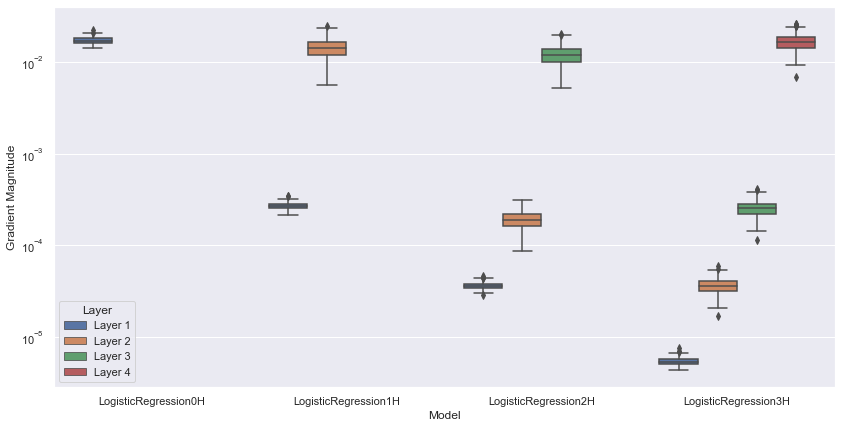

In [22]:
# Prepare collected gradients for plotting.
gradient_dfs = []
for model, gradient in gradients:
    gradient_data = pd.DataFrame(gradient)
    gradient_data.columns = [f"Layer {i + 1}" for i in range(len(gradient))]
    gradient_data = pd.melt(gradient_data, var_name="Layer", value_name="Gradient Magnitude")
    gradient_data["Model"] = type(model).__name__
    gradient_dfs.append(gradient_data)

# Combine all gradients in a single data frame.
gradients_df = pd.concat(gradient_dfs)

# Define plotting figure and corresponding attributes.
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.set(yscale='log')

# Plot pre-processed gradients.
sns.boxplot(x='Model', y='Gradient Magnitude', hue='Layer', data=gradients_df, ax=ax)
plt.show()

<a name="vanishing-gradient"></a><h2>The Vanishing Gradient Problem (Revised)</h2>
<p>The <i>Vanishing Gradient Problem</i> describes the effect of <i>losing</i> the error signal on its way from the loss function to the network's input. As a result, the gradients in the lower layers of a network receive almost no error signal to adapt the parameters accordingly. It is especially pronounced in deep neural networks, so more layers can be counterproductive.</p>

<a name="vanishing-gradient-culprit"></a><h3 style="color:rgb(0,120,170)">The primary culprit</h3>
<p>Remember the <i>backward</i> pass as discussed earlier in this unit. Gradients multiply according to the <i>chain rule</i>. Hence, with respect to our logistic regression models, this includes many derivatives of the sigmoid activation function.

<center>
    \begin{align*}
    \mathbf{W}_4 & \leftarrow \mathbf{W}_4 - \eta \frac{\partial L}{\partial \mathbf{W}_4} \\
    \mathbf{W}_3 & \leftarrow \mathbf{W}_3 - \eta \frac{\partial L}{\partial h_3}\frac{\partial h_3}{\partial \mathbf{W}_3} \\
    \mathbf{W}_2 & \leftarrow \mathbf{W}_2 - \eta \frac{\partial L}{\partial h_3}\frac{\partial h_3}{\partial h_2}\frac{\partial h_2}{\partial \mathbf{W}_2} \\
    \mathbf{W}_1 & \leftarrow \mathbf{W}_1 - \eta \underbrace{\frac{\partial L}{\partial h_3}}_{\propto~ \sigma'}\underbrace{\frac{\partial h_3}{\partial h_2}}_{\propto~\sigma'}\underbrace{\frac{\partial h_2}{\partial h_1}}_{\propto~\sigma'}\underbrace{\frac{\partial h_1}{\partial \mathbf{W}_1}}_{\propto~\sigma'}
    \end{align*}
</center>

For this very reason, let's have a closer look at the <i>sigmoid</i> activation function and its derivative.</p>

In [23]:
def sigmoid(x: float) -> float:
    """
    Compute the logistic function.
    
    :param x: the input on which to apply the logistic function
    :return: the result of the logistic function applied to its input
    """
    return 1.0 / (1.0 + math.exp(-x))


def sigmoid_d(x: float) -> float:
    """
    Compute the derivate of the logistic function.
    
    :param x: the input to the logistic function for computing its derivative
    :return: the derivative of the logistic function with respect to its input
    """
    return sigmoid(x) * (1.0 - sigmoid(x))


# Crudly check the value range of the sigmoid function and its derivative.
for x in [-10.0, 0.0, 10.0]:
    print(f'sigmoid({x:>5}): {sigmoid(x):.4f} | sigmoid\'({x:>5}): {sigmoid_d(x):.4f}')

sigmoid(-10.0): 0.0000 | sigmoid'(-10.0): 0.0000
sigmoid(  0.0): 0.5000 | sigmoid'(  0.0): 0.2500
sigmoid( 10.0): 1.0000 | sigmoid'( 10.0): 0.0000


<p>The previous computation of the value range of the sigmoid function and its derivative already suggests that the derivative vanishes if the corresponding input is either <i>small</i> or <i>big</i> – which already seems problematic. For a more thorough analysis, let's visualize the value ranges accordingly.</p>

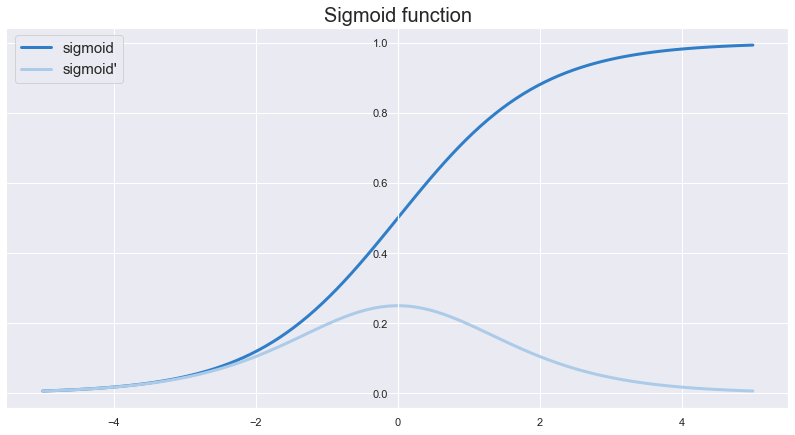

In [24]:
def plot_sigmoid_with_derivative(x_min: float = -5.0, x_max: float = 5.0, granularity: int = 1000) -> None:
    """
    Plot the logistic function including its derivative.
    
    :param x_min: minimum value of the input value range
    :param x_max: maximum value of the input value range
    :param granularity: granularity controlling the stepsize of the input value range
    """
    data = np.linspace(x_min, x_max, granularity)

    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['left'].set_position('center')

    plt.plot(data, tuple(map(sigmoid, data)), color='#307EC7', linewidth=3, label='sigmoid')
    plt.plot(data, tuple(map(sigmoid_d, data)), color='#accbe8', linewidth=3, label="sigmoid'")
    plt.title('Sigmoid function', fontsize=20)
    plt.legend(prop={'size': 15})
    plt.show()

# Plot logistic function including its derivative.
plot_sigmoid_with_derivative()

<a name="vanishing-gradient-relu"></a><h3 style="color:rgb(0,120,170)">Rectified linear units to the rescue</h3>
<p>It seems quite clear, that we need to exchange the <i>sigmoid</i> activation function with a different one. Ideally, the new activation function should have a derivative close to $1$ in order to mitigate a <i>vanishing gradient</i> (likewise an <i>exploding gradient</i>). A common activation function is the <i>rectified linear unit</i> (often abbreviated as <i>ReLU</i>), which is easy and efficient to compute and provides a derivative of <i>exactly</i> $1$ for all positive inputs.</p>

In [25]:
def relu(x: float) -> float:
    """
    Compute the rectified linear unit function.
    
    :param x: the input on which to apply the rectified linear unit function
    :return: the result of the rectified linear unit function applied to its input
    """
    return max(0.0, x)


def relu_d(x: float) -> float:
    """
    Compute the derivate of the rectified linear unit function.
    
    :param x: the input to the rectified linear unit function for computing its derivative
    :return: the derivative of the rectified linear unit function with respect to its input
    """
    return 0.0 if x <= 0.0 else 1.0


# Crudly check the value range of the rectified linear unit function and its derivative.
for x in [-10.0, 0.0, 10.0]:
    print(f'relu({x:>5}): {relu(x):7.4f} | relu\'({x:>5}): {relu_d(x):.4f}')

relu(-10.0):  0.0000 | relu'(-10.0): 0.0000
relu(  0.0):  0.0000 | relu'(  0.0): 0.0000
relu( 10.0): 10.0000 | relu'( 10.0): 1.0000


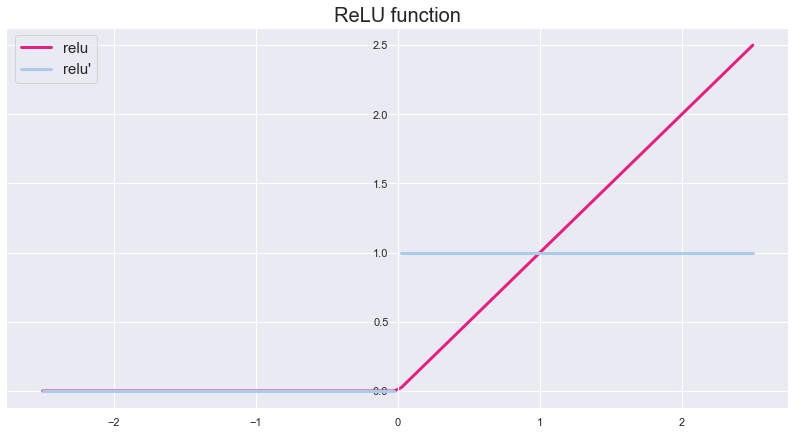

In [26]:
def plot_relu_with_derivative(x_min: float = -2.5, x_max: float = 2.5, granularity: int = 1000) -> None:
    """
    Plot the rectified linear unit function including its derivative.
    
    :param x_min: minimum value of the input value range
    :param x_max: maximum value of the input value range
    :param granularity: granularity controlling the stepsize of the input value range
    """
    data = np.linspace(x_min, x_max, granularity)
    data_pivot_neg = np.where(data <= 0)
    data_pivot_pos = np.where(data > 0)

    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['left'].set_position('center')

    plt.plot(data, tuple(map(relu, data)), color='#e22182', linewidth=3, label='relu')
    # Plot derivative of negative/positive data separately to avoid a linked line plot.
    if len(data_pivot_neg) > 0:
        data_neg = data[data_pivot_neg]
        plt.plot(data_neg, tuple(map(relu_d, data_neg)), color='#accbe8', linewidth=3, label="relu'")
    if len(data_pivot_pos) > 0:
        data_pos = data[data_pivot_pos]
        plt.plot(data_pos, tuple(map(relu_d, data_pos)), color='#accbe8', linewidth=3)
    plt.title('ReLU function', fontsize=20)
    plt.legend(prop={'size': 15})
    plt.show()

# Plot rectified linear unit function including its derivative.
plot_relu_with_derivative()

<a name="training-relu"></a><h3 style="color:rgb(0,120,170)">Training of a ReLU-Network</h3>
<p>After analyzing the value range of the <i>rectified linear unit</i> function including its derivative, we are now creating a corresponding network to check how the performance changes with respect to the previous <code>LogisticRegression3H</code> implementation.</p>

In [27]:
class ReLU3H(torch.nn.Module):
    """
    ReLU network tailored to process Fashion-MNIST data.
    """
    
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 28 * 28)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.fc1.out_features, self.fc1.out_features)
        self.ac2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(self.fc2.out_features, self.fc2.out_features)
        self.ac3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(self.fc3.out_features, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return self.fc4(x)

In [28]:
# Set random seed for reproducibility.
u2.set_seed(0)

# Create ReLU network instance and the corresponding optimizer to use.
relu_model = ReLU3H().to(target_device)
optimizer = torch.optim.SGD(relu_model.parameters(), lr=1e-3)

# Show the architecture of the ReLU network model.
print(relu_model)

ReLU3H(
  (fc1): Linear(in_features=784, out_features=784, bias=True)
  (ac1): ReLU()
  (fc2): Linear(in_features=784, out_features=784, bias=True)
  (ac2): ReLU()
  (fc3): Linear(in_features=784, out_features=784, bias=True)
  (ac3): ReLU()
  (fc4): Linear(in_features=784, out_features=10, bias=True)
)


In [29]:
# Set random seed for reproducibility.
u2.set_seed(0)

# Train and evaluate ReLU network instance on the Fashion-MNIST training set.
train_and_evaluate(
    model=relu_model,
    optimizer=optimizer,
    device=target_device,
    num_epochs=3,
    loader_train=loader_fashion_mnist_train,
    loader_test=loader_fashion_mnist_test
)

Epoch: 1 / Train loss: 0.0179 / Train accuracy: 0.1850
Epoch: 2 / Train loss: 0.0178 / Train accuracy: 0.2203
Epoch: 3 / Train loss: 0.0177 / Train accuracy: 0.2431

Test loss: 0.0177 / Test accuracy: 0.2410


<p>Compared to the 3-layer logisitc regression model from above, the results seem to have improved significantly. We are performing a corresponding <i>gradient analysis</i> to investigate if the <i>vanishing gradient</i> is now absent. Assumptions are all nice and good, but a in a proper workflow, checking of assumptions is a <i>must</i> (if possible). For this very reason, we are creating <i>new</i> instances of <code>ReLU3H</code> as well as <code>LogisticRegression3H</code> for a comparison.</p>

In [30]:
models = []
for model_class in [LogisticRegression3H, ReLU3H]:
    # Set random seed for reproducibility.
    u2.set_seed(0)
    
    # Create logistic regression models.
    models.append(model_class().to(target_device))

gradients = [(model, collect_gradients(model=model, device=target_device, loader=loader_fashion_mnist_train)) for model in models]

<p>After collecting all parameter gradients of the rectified linear unit as well as the corresponding logistic regression model, an adequate comparing visualization is well suited to illustrate the <i>Vanishing Gradient Problem</i> (or its <i>absence</i>).</p>

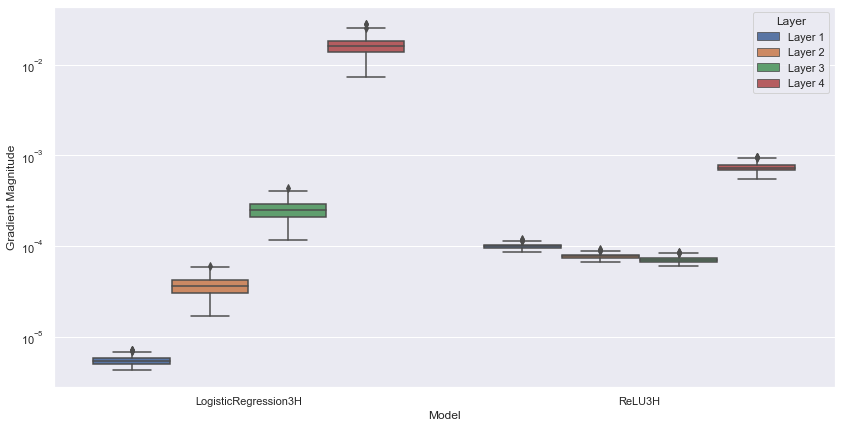

In [31]:
# Prepare collected gradients for plotting.
gradient_dfs = []
for model, gradient in gradients:
    gradient_data = pd.DataFrame(gradient)
    gradient_data.columns = [f"Layer {i + 1}" for i in range(len(gradient))]
    gradient_data = pd.melt(gradient_data, var_name="Layer", value_name="Gradient Magnitude")
    gradient_data["Model"] = type(model).__name__
    gradient_dfs.append(gradient_data)

# Combine all gradients in a single data frame.
gradients_df = pd.concat(gradient_dfs)

# Define plotting figure and corresponding attributes.
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.set(yscale='log')

# Plot pre-processed gradients.
sns.boxplot(x='Model', y='Gradient Magnitude', hue='Layer', data=gradients_df, ax=ax)
plt.show()